In [1]:
import pathlib
import os
import sys

pypath = os.path.join(str(pathlib.Path.cwd().parent.parent))
sys.path.append(pypath)

In [6]:
import json
import math

import numpy as np
import pandas as pd

from bofire.benchmarks.benchmark import Benchmark
from bofire.domain import Domain
from bofire.domain.features import (
    CategoricalDescriptorInput,
    CategoricalInput,
    ContinuousInput,
    ContinuousOutput,
    InputFeature,
    InputFeatures,
    OutputFeatures,
)
from bofire.domain.objectives import MaximizeObjective, MinimizeObjective
from bofire.utils.enum import CategoricalEncodingEnum, CategoricalMethodEnum
from bofire.models.feature_importance import permutation_importance_hook, combine_permutation_importances

from bofire.benchmarks.multi import CrossCoupling
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.samplers import PolytopeSampler
from bofire.strategies.random import RandomStrategy
from bofire.strategies.botorch.qparego import BoTorchQparegoStrategy
from functools import partial

In [3]:
def sample(domain):
    sampler = PolytopeSampler(domain=domain)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain) -> float:
    assert domain.experiments is not None
    return compute_hypervolume(
        domain, domain.experiments, ref_point={"yield": 0.0, "cost": 1.0}
    )

In [4]:
results = run(
    CrossCoupling(descriptor_encoding=CategoricalEncodingEnum.DESCRIPTOR),
    strategy_factory=partial(BoTorchQparegoStrategy, 
                            ref_point={"yield": 0.0, "cost": 1.0}, 
                            categorical_method=CategoricalMethodEnum.FREE, 
                            descriptor_method=CategoricalMethodEnum.FREE),
    n_iterations=50,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.809:  22%|██▏       | 11/50 [02:25<08:21, 12.85s/it]c:\Users\J32616\Repositories\bofire\venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
c:\Users\J32616\Repositories\bofire\venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
c:\Users\J32616\Repositories\bofire\venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
c:\Users\J32616\Repositories\bofire\venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
c:\Users\J32616\Repositories\bofire\venv\lib\site-packages\linear_operator\utils\cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(
c

In [7]:
random_results = run(
    CrossCoupling(descriptor_encoding=CategoricalEncodingEnum.DESCRIPTOR),
    strategy_factory=RandomStrategy,
    n_iterations=50,
    metric=hypervolume,
    #initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.778: 100%|██████████| 50/50 [00:01<00:00, 29.43it/s]


Text(0, 0.5, 'cost')

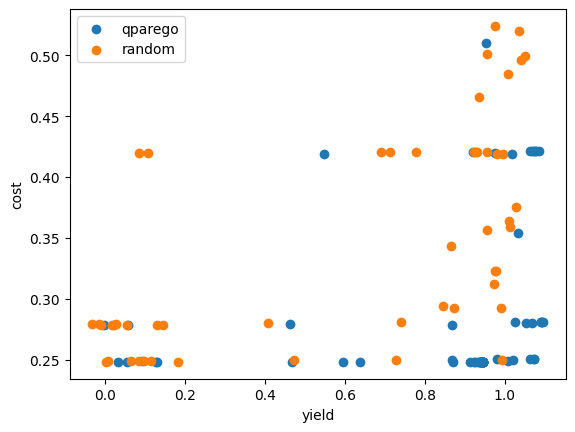

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(results[0][0].domain.experiments['yield'], results[0][0].domain.experiments['cost'], label = "qparego")
ax.scatter(random_results[0][0].domain.experiments['yield'], random_results[0][0].domain.experiments['cost'], label = "random")

ax.legend()

ax.set_xlabel("yield")
ax.set_ylabel("cost")